In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
import requests
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
res = requests.get(url, allow_redirects=True)
with open('time_series_covid19_confirmed_global.csv','wb') as file:
    file.write(res.content)
    
glob_data = pd.read_csv('time_series_covid19_confirmed_global.csv')


taiwan_data = glob_data[glob_data['Country/Region'] == 'Taiwan*']
taiwan_cases = taiwan_data.values.tolist()[0][4:]

us_data = glob_data[glob_data['Country/Region'] == 'US']
us_cases = us_data.values.tolist()[0][4:]

In [13]:
us_df = pd.DataFrame()
us_df['Infected'] = us_cases
days = np.arange(0,len(us_df['Infected'])).tolist()
us_df['Day'] = days    #

In [14]:
us_df['New Infected'] =  us_df['Infected'] - us_df['Infected'].shift(1)
us_df['New Infected'].iloc[0] = 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
taiwan_df = pd.DataFrame()
taiwan_df['Infected'] = taiwan_cases
days = np.arange(0,len(taiwan_df['Infected'])).tolist()
taiwan_df['Day'] = days    
taiwan_df['New Infected'] =  taiwan_df['Infected'] - taiwan_df['Infected'].shift(1)
taiwan_df['New Infected'].iloc[0] = 1

# Notes
- The runge kutta method has reduced to the code shown below. Unsure if this is correct but it produces reasonable plots for S, I, and R
- Fitting data against the model, it is apparent that the model overpredicts a flattening of the curve
    - Surely, there will be flattening in the months to come, but in most countries the rate of infection is still on the rise
    - Because of this, I have tested several different countries of varying infection curves and population sizes:
        - Taiwan: More flattening in data, current infections < 1M
        - US: Still on the rise, model overpredicts flattening. Current infectious <10M
   

In [16]:
def SIR_model(t, k,gamma,pop): # Dont fit gamma
    xplot = [0]
   # gamma = 1/18 # I need to make this an initial condition. This fails horribly when fitting
    N = pop
    h = 1 # steps
    I = [1] # Initial infections always start at 1 
    S = [N-I[0]]  # 10000-1 initially susceptible
    R = [0] # 0 recovered initially
    m = 1/30 # Government stringency 
    
    for i in t:
        x = xplot[i]
        
        kS1 = -k*S[i]*I[i]/N      
        kI1 = k*S[i]*I[i]/N - gamma*I[i]
        kR1 = gamma*I[i]
        
        yS = S[i] + h*kS1
        yI = I[i] + h*kI1
        yR = R[i] + h*kR1
        
        xplot.append(x+h)
        S.append(yS)
        I.append(yI)
        R.append(yR)   # Removed ~ 
    return I[:-1]

#a,b,c = SIR_model(range(0,200),5/14, 0.05, 28000000)

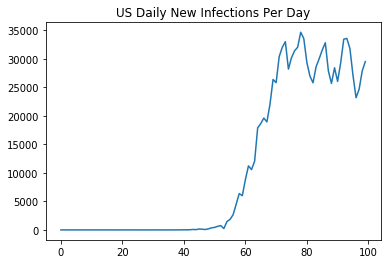

In [26]:
us_df = us_df[0:100]
plt.title("US Daily New Infections Per Day")
plt.plot(us_df['Day'], us_df['New Infected'])

# Important to test model solutions with varying parameters to see how it behaves

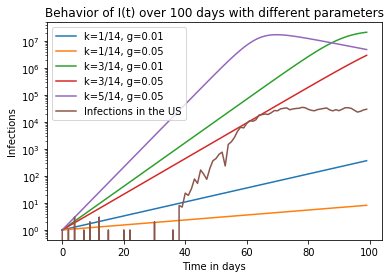

In [28]:
plt.plot(range(0,100), SIR_model(range(0,100),1/14, 0.01, 28000000), label="k=1/14, g=0.01")
plt.plot(range(0,100), SIR_model(range(0,100),1/14, 0.05, 28000000), label="k=1/14, g=0.05")
plt.plot(range(0,100), SIR_model(range(0,100),3/14, 0.01, 28000000), label="k=3/14, g=0.01")
plt.plot(range(0,100), SIR_model(range(0,100),3/14, 0.05, 28000000), label="k=3/14, g=0.05")
plt.plot(range(0,100), SIR_model(range(0,100),5/14, 0.05, 28000000), label="k=5/14, g=0.05")
plt.yscale('log')
plt.plot(us_df['Day'], us_df['New Infected'], label = "Infections in the US")
plt.ylabel("Infections")
plt.xlabel("Time in days")
plt.title('Behavior of I(t) over 100 days with different parameters')
plt.legend(loc='best')

In [ ]:
plt.plot()

In [1]:
us_df = us_df.iloc[0:250]
taiwan_df = taiwan_df.iloc[0:250]

NameError: name 'us_df' is not defined

### For most countries, we want to model smaller gamma and small k for a more extended growth period in infections
- Large k causes earlier spike
- Large gamma causes smaller spike, later

In [130]:
from scipy.optimize import curve_fit   # our main fitting optimizer (reduces error while finding best fit)
from scipy import optimize
from sklearn.metrics import mean_squared_error
from scipy import stats

params, params_covariance = optimize.curve_fit(SIR_model, taiwan_df['Day'], taiwan_df['New Infected'], 
                                               p0=[3/14, 28000000], maxfev=5000)

prediction = SIR_model(taiwan_df['Day'], params[0], params[1])
target = taiwan_df['New Infected']

y = mean_squared_error(target, prediction)

print("Taiwan: Best values for k: ", round(params[0],4), "+/-", round(np.sqrt(np.diag(params_covariance))[0],4))
#print("Taiwan: Best values for gamma: ", round(params[1],4), "+/-", round(np.sqrt(np.diag(params_covariance))[1],4))
print("Taiwan: mean squared error between fit and data:", y)
chi = stats.chisquare(f_obs = target, f_exp = prediction)
print("Taiwan: chi squared error between fit and data:", chi)

Taiwan: Best values for k:  0.1183 +/- 0.0044
Taiwan: mean squared error between fit and data: 14.12893067825439
Taiwan: chi squared error between fit and data: Power_divergenceResult(statistic=3064.1278563649876, pvalue=0.0)


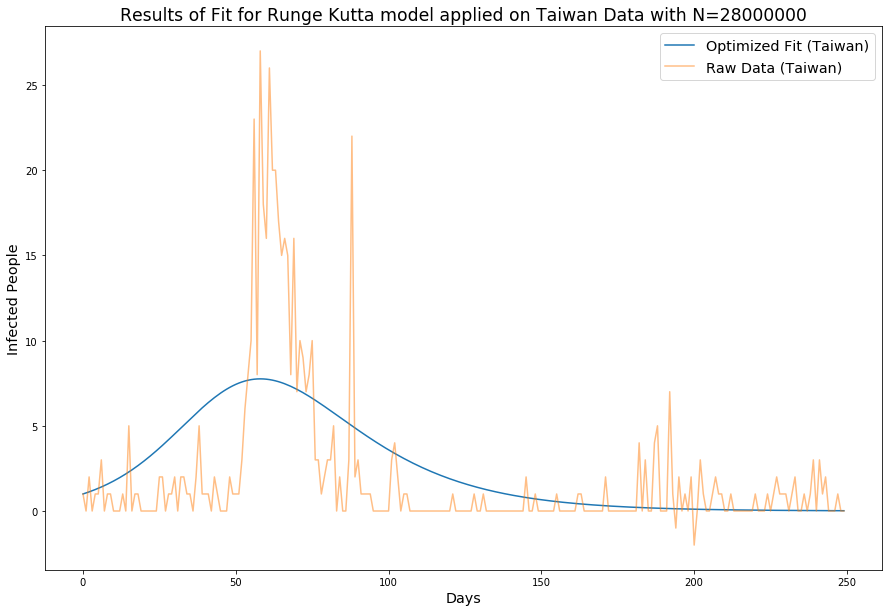

In [131]:
plt.figure(figsize=(15,10))
plt.plot(taiwan_df['Day'], prediction, label="Optimized Fit (Taiwan)", alpha=1.0)
plt.plot(taiwan_df['Day'], taiwan_df['New Infected'], label='Raw Data (Taiwan)', alpha = 0.5)
plt.title("Results of Fit for Runge Kutta model applied on Taiwan Data with N=28000000", fontsize="xx-large")
plt.xlabel("Days", fontsize = "x-large")
plt.ylabel("Infected People", fontsize = "x-large")
plt.legend(loc='best')
plt.legend(fontsize="x-large")
plt.show()

US: Best values for k:  0.128 +/- 0.0006
US: mean squared error between fit and data: 231252799.1203866
US: chi squared error between fit and data: Power_divergenceResult(statistic=125422145.24627349, pvalue=0.0)


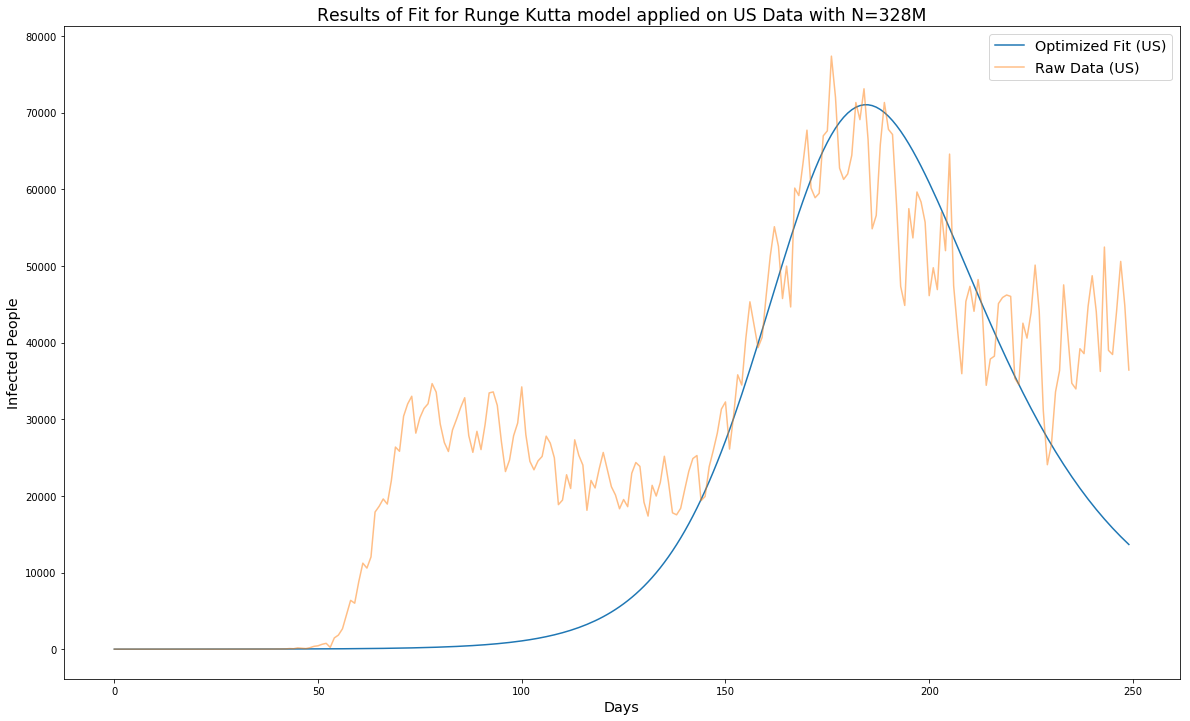

In [132]:
par, cov = optimize.curve_fit(SIR_model, us_df['Day'], us_df['New Infected'], 
                                               p0=[2/14, 328000000], maxfev=5000)

pred1= SIR_model(us_df['Day'], par[0], par[1])
target1=us_df['New Infected']

y1= mean_squared_error(target1, pred1)



print("US: Best values for k: ", round(par[0],4), "+/-", round(np.sqrt(np.diag(cov))[0],4))
#print("US: Best values for gamma: ", round(par[1],4), "+/-", round(np.sqrt(np.diag(cov))[1],4))
print("US: mean squared error between fit and data:", y1)
chi1 = stats.chisquare(f_obs = target1, f_exp = pred1)
print("US: chi squared error between fit and data:", chi1)


plt.figure(figsize=(20,12))
plt.plot(us_df['Day'], pred1, label="Optimized Fit (US)", alpha=1.0)
plt.plot(us_df['Day'], us_df['New Infected'], label='Raw Data (US)', alpha = 0.5)

plt.title("Results of Fit for Runge Kutta model applied on US Data with N=328M", fontsize="xx-large")
plt.xlabel("Days", fontsize = "x-large")
plt.ylabel("Infected People", fontsize = "x-large")
plt.legend(loc='best')
plt.legend(fontsize="x-large")

plt.show()